## Exploratory Data Analysis
---

Exploring categories of bird species and their distributions

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os, random
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train = pd.read_csv("/kaggle/input/birdsong-recognition/train.csv")
test = pd.read_csv("/kaggle/input/birdsong-recognition/test.csv")

In [ ]:
train.head()

In [ ]:
train.columns

In [ ]:
# Bird species:
print("Bird species:\n {}".format(train.ebird_code.unique()))

In [ ]:
# Bird species:
print("No. of Unique bird species:\n {}".format(len(train.ebird_code.unique())))

In [ ]:
# Distribution of categories
ax = train.groupby(['country']).ebird_code.nunique().sort_values(ascending=False)[:6].plot.bar(figsize=(10,10),
                                                                                         rot=0,
                                                                                         title="Top 5 Countries with most number of unique species")

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center',                              xytext=(0, 10),                               textcoords='offset points')

Looks like a lot of species of birds have audio clips gathered in the US

### Duration of clips:
---

In [ ]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=train['duration'])

In [ ]:
ax = sns.kdeplot(train['duration'])

In [ ]:
print("Mean duration: {}".format(np.mean(train['duration'])))
print("Median duration: {}".format(np.median(train['duration'])))
print("Min duration: {}".format(np.min(train['duration'])))
print("Max duration: {}".format(np.max(train['duration'])))

Duration of our clips vary widely from < 1 s to ~55 s

Example of clip with very very short recording:

In [ ]:
# List out the bird species:
train_folder_path = '/kaggle/input/birdsong-recognition/train_audio/'

In [ ]:
import IPython.display as ipd
sample_file = train_folder_path + 'amebit/' + 'XC310046.mp3'
print(sample_file)
ipd.Audio(sample_file)

In [ ]:
train['sampling_rate'].unique()

## Missing Values
---

We need to check if there are any missing values and if we need to perform any imputation

In [ ]:
train.isnull().sum()

## Reading Audio as numpy array
---

To get started, we can read in each audio file as a numpy array. This can be done using the <ins>librosa</ins> library: https://librosa.github.io/librosa/

In [ ]:
import librosa

clip, sample_rate = librosa.load(sample_file, sr=None)
clip = clip[:132300] # first three seconds of file

In [ ]:
clip

Before we dive into modelling, there is 2 components we need to understand

1. Structure of submissions (We need to understand how submissions work so we can train our model in the same structure)
2. Concepts of audio processing

## Structure of submissions
---
What we need to do in the inference phase is

* Read test.csv
* Repeat 3 - 5 for each row in test.csv
* Open test audio file which is contained in /kaggle/input/birdsong-recognition/test_audio and named like audio_id.mp3 .
* If site is site_3 use the whole clip, otherwise cut 5 seconds short clip out of the long audio clip which we loaded in step3 that ends in the second specified in seconds column.
* Perform prediction on the short clip which we prepared in step 4. Note that each clip may have multiple labels.

See: https://www.kaggle.com/c/birdsong-recognition/discussion/158987

The important point to take note is that in our training phase, we need to account for different durations of audio clips depending on the site the clip is extracted from is on.

Below is an example of a function that can help us to read in the clips:

In [ ]:
# From https://www.kaggle.com/cwthompson/birdsong-making-a-prediction
'''
Loading Audio
Firstly, we need to be able to read in five second windows of the test audio. We can do this using librosa. 
If the audio is from site 3 then we need to whole audio clip, and we can do this by setting duration to None.
'''

def load_test_clip(path, start_time, duration=5):
    return librosa.load(path, offset=start_time, duration=duration)[0]

## Basics of sound

### What is sound?
---

* Sound is a vibration that propagates as an acoustic wave. This is due to alternations in pressure as a result of vibrations of air molecules

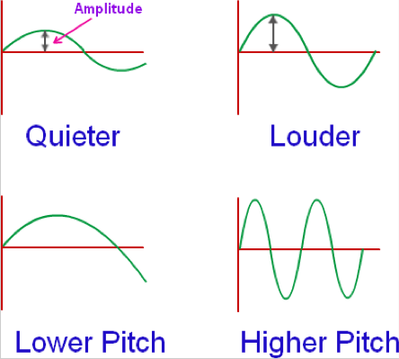


### Analog Digital Conversion (ADC)
---

* Signal sampled at uniform time intervals
* Amplitude quantized with limited no. of bits

### Sampling Rate & Bit Depth
---

* Sampling_rate: Number of amplitude points taken in a second
* Bit Depth: the number of bits of information in each sample, and it directly corresponds to the resolution of each sample

### Fourier Transform
---
* Decompose complex periodic sound into sum of sine waves oscillating at different frequencies
* When performing FT, we move from time to frequency domain

<ins>**Fast Fourier Transform:**</ins>
* The <ins>**Fast Fourier transform (FFT)**</ins> is an algorithm to compute the periodic structure in the signal, but representing it by a set of sine waves, called frequencies. Plotting the power of each one of those frequencies gives the Power Spectrum:

<ins>**Example of Fast Fourier Transform:**</ins>
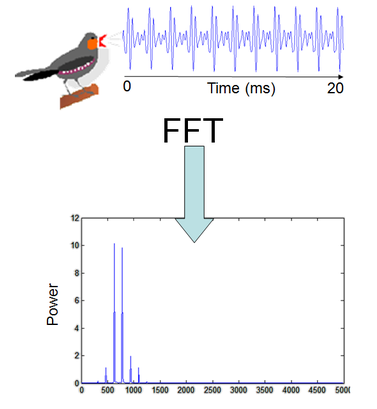

<ins>**Short Time Fast Fourier Transform:**</ins>
* Computes several FFT at different intervals
* Preserves time information
* Fixed frame size (eg 2048 samples)
* Gives a spectrogram (time + frequency + magnitude)


<ins>**Example of Short Time Fast Fourier Transform:**</ins>
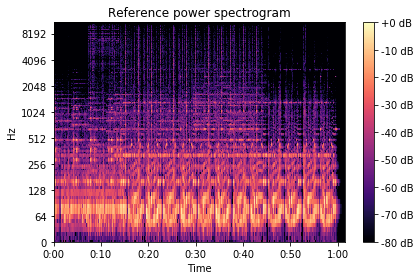

### Pipelines for sound classification
---

<ins>*1. Traditional Machine Learning Pipeline:*</ins>

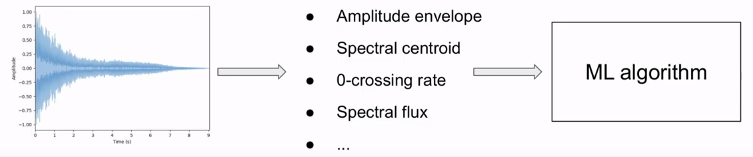

* Feature engineering
* Performing STFT
* Extract Time + frequency domain features

<ins>2. DL Pipeline:</ins>

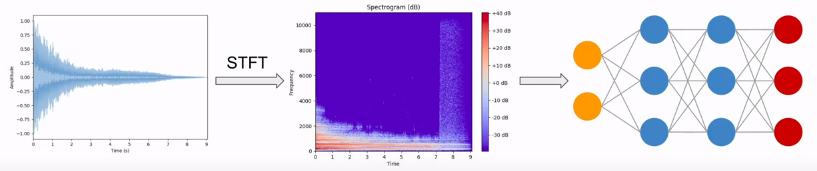


### Mel-Frequency Cepstral Coefficients (MFCC)
---

* Essentially captures timbral/textural aspects of sound
* Frequency domain of sound
* Aproximates human auditory system
* The main difference beween a spectrogram and MFCC is that a spectrogram uses a linear spaced frequency scale (so each frequency bin is spaced an equal number of Hertz apart), whereas an MFCC uses a quasi-logarithmic spaced frequency scale, which is more similar to how the human auditory system processes sounds.



From Wikipedia:
In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC



For more information: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

Illustration showing differences in audio processing techniques:

<img src="https://miro.medium.com/max/996/1*H_lcPB14mWwXrbN_ibIeGw.jpeg" alt="drawing" height="300" width="650" />

In [ ]:
import librosa, librosa.display
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 10)

SOUND_DIR= train_folder_path + 'amebit/' + 'XC310046.mp3'

# Generate waveform plot
signal, sr = librosa.load(SOUND_DIR, sr= 22050)
librosa.display.waveplot(signal, sr = sr)
plt.title("Waveform:")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# fft -> spectrum
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_frequency  = frequency[:int(len(frequency)/2)]
left_magnitude  = magnitude[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitude)
plt.title("Fast Fourier Transform:")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# stft -> spectrogram

# Number of samples per FFT
n_fft = 2048

# Amount we are shifting each FFT to the right
hop_length = 512

stft = librosa.core.stft(signal, hop_length = hop_length, n_fft = n_fft)

spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length = hop_length)
plt.title("Spectrogram using STFT:")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [ ]:
#MFCCs:
mfccs = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
librosa.display.specshow(mfccs, sr=sr, hop_length = hop_length)
plt.title("Spectrogram using MFCC:")
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

* ### Building Spectrograms
---

In [ ]:
import librosa
import cv2
#from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
#     X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def build_spectrogram(path):
    y, sr = librosa.load(path)
    total_secs = y.shape[0] / sr
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    M = librosa.power_to_db(M)
    M = mono_to_color(M)
    
    cv2.imwrite(path.split("/")[-1][:-4] + ".jpg", M, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
    M = cv2.imread(path.split("/")[-1][:-4] + ".jpg", 0)
    M = np.repeat(M[...,None],3,2)/255.
    os.remove(path.split("/")[-1][:-4] + ".jpg")
    return M

In [ ]:
M = build_spectrogram("../input/birdsong-recognition/example_test_audio/BLKFR-10-CPL_20190611_093000.pt540.mp3")

In [ ]:
plt.imshow(M[:, :500])

Reference: https://www.kaggle.com/ryches/birdsong-keras-starter/notebook?scriptVersionId=36635693

In [ ]:
import cv2
import matplotlib.pyplot as plt
base_path = "../input/birdsongspectrograms/"
def read_img(img_path):
    img = cv2.imread(base_path + img_path[:-3] + "jpg", 0)
    return img

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit_transform(train["ebird_code"])

In [ ]:
import joblib
joblib.dump(le, 'birdcalls_label_encoder.pkl')

In [ ]:
files = [file[:-3] + "mp3" for file in os.listdir(base_path)]

In [ ]:
train = train[train["filename"].isin(files)]

**fastai model:**
---

In [ ]:
!pip install efficientnet_pytorch


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from fastai import *
from fastai.vision import *
from efficientnet_pytorch import *
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

In [ ]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

In [ ]:
bs = 12 #smaller batch size is better for training, but may take longer

sz = 256

In [ ]:
### t2 = train.copy()
train_dir = os.path.join('../', 'input/birdsongspectrograms/')
t3 = train[['filename', 'ebird_code']]
t3['ebird_code'] = t3['ebird_code'].apply(lambda x: le.transform([x])[0])
t3['path'] = t3['filename'].map(lambda x: os.path.join(train_dir,'{}.jpg'.format(x[:-4])))
t3 = t3.drop(columns=['filename'])

In [ ]:
from fastai.callbacks.hooks import *

src = (ImageList.from_df(df=t3,path = '',cols='path')
       .split_by_rand_pct(0.2) #split the dataset such that we have 20% as validation set
       .label_from_df(cols='ebird_code',label_cls=CategoryList))

data= (src.transform(tfms=None, size=sz, padding_mode='zeros',
                     resize_method=ResizeMethod.SQUISH).databunch(bs=bs,num_workers=4).normalize(imagenet_stats))

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
data.one_item

In [ ]:
model_name = 'efficientnet-b3'

def get_model(pretrained=True):
    model = EfficientNet.from_pretrained(model_name, num_classes=data.c)
    return model


# F1 = MultiLabelFbeta(beta=2, average="macro")
learn = Learner(data, get_model(True), metrics = [top_k_accuracy]).mixup().to_fp16()
learn.model_dir = "/kaggle/working"

In [ ]:
learn.unfreeze()

In [ ]:
from fastai.callbacks import * 

learn.fit_one_cycle(1,1e-3, callbacks=[SaveModelCallback(learn, every='improvement', 
                                                 monitor='valid_loss', name='best_saved')])

In [ ]:
learn.save('fastai_effnetb3', return_path=True)

## Plan for modelling
---

To try RNN

## Acknowledgements:
---
https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data  
https://www.youtube.com/watch?v=m3XbqfIij_Y

Bird Spectrograms from: https://www.kaggle.com/ryches/birdsongspectrograms